# 자전거 배치 및 운영 전략 최적화 : 수요 예측 모델 개발

[목차]

1. 개요
    - 배경
    - 분석 목적
    - 분석 목표
    - 데이터 설명
    - 라이브러리 호출

2. 데이터 전처리
    - EDA
    - 결측치 처리
    - 중복값 처리
    - 이상치 처리
    - 표준화
    - QQ-plot으로 정규성 검증
    
3. 예측 모델 개발
    - 회귀 모델 실험(선형/릿지/라쏘)

5. 결론

---
---

## 개요

### 1) 배경
- 자전거 대여 시스템의 운영 담당자로, 최적화된 자전거 배치 및 운영 전략을 기획하여 사용자 만족도를 제고시키고 시스템의 효율성을 증가시키는 것이 요구됨

### 2) 분석 목적
- 자전거 대여 패턴을 분석하여 자전거 배치 및 운영 전략을 최적화하고, 대여 수요를 정확히 예측하여 대여 시스템의 효율성을 높이고 사용자 만족도를 증가시키기 위함

### 3) 분석 목표
- 다양한 머신러닝 모델과 전략을 실험하여 가장 정확한 수요 예측 모델을 개발

- 모델의 핵심 평가 지표인 RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것

### 4) 데이터 설명

| 컬럼명       | 데이터 타입 | 설명                                           |
|-------------|------------|----------------------------------------------|
| datetime    | datetime   | 자전거 대여 기록의 날짜 및 시간. 예시: 2011-01-01 00:00:00 |
| season      | int        | 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)      |
| holiday     | int        | 공휴일 여부 (0: 평일, 1: 공휴일)              |
| workingday  | int        | 근무일 여부 (0: 주말/공휴일, 1: 근무일)       |
| weather     | int        | 날씨 상황 (1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| temp        | float      | 실측 온도 (섭씨)                              |
| atemp       | float      | 체감 온도 (섭씨)                              |
| humidity    | int        | 습도 (%)                                      |
| windspeed   | float      | 풍속 (m/s)                                   |
| casual      | int        | 등록되지 않은 사용자의 대여 수                |
| registered  | int        | 등록된 사용자의 대여 수                      |
| count       | int        | 총 대여 수 (종속 변수)                        |

### 5) 라이브러리 호출 및 데이터 프레임 생성

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
# train 데이터 셋 호출
train_df = pd.read_csv('./data/train.csv')
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
# test 데이터 셋 호출
test_df = pd.read_csv('./data/test.csv')
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


---

## 데이터 전처리

### EDA

#### 1) 기술통계분석 및 데이터 확인

> #### train 데이터

In [4]:
train_df.shape

(10886, 12)

In [5]:
# 기술 통계 확인
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 변수간 스케일 차이 존재 => Feature Scaling 작업 요구됨

In [6]:
# 컬럼별 정보 확인
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


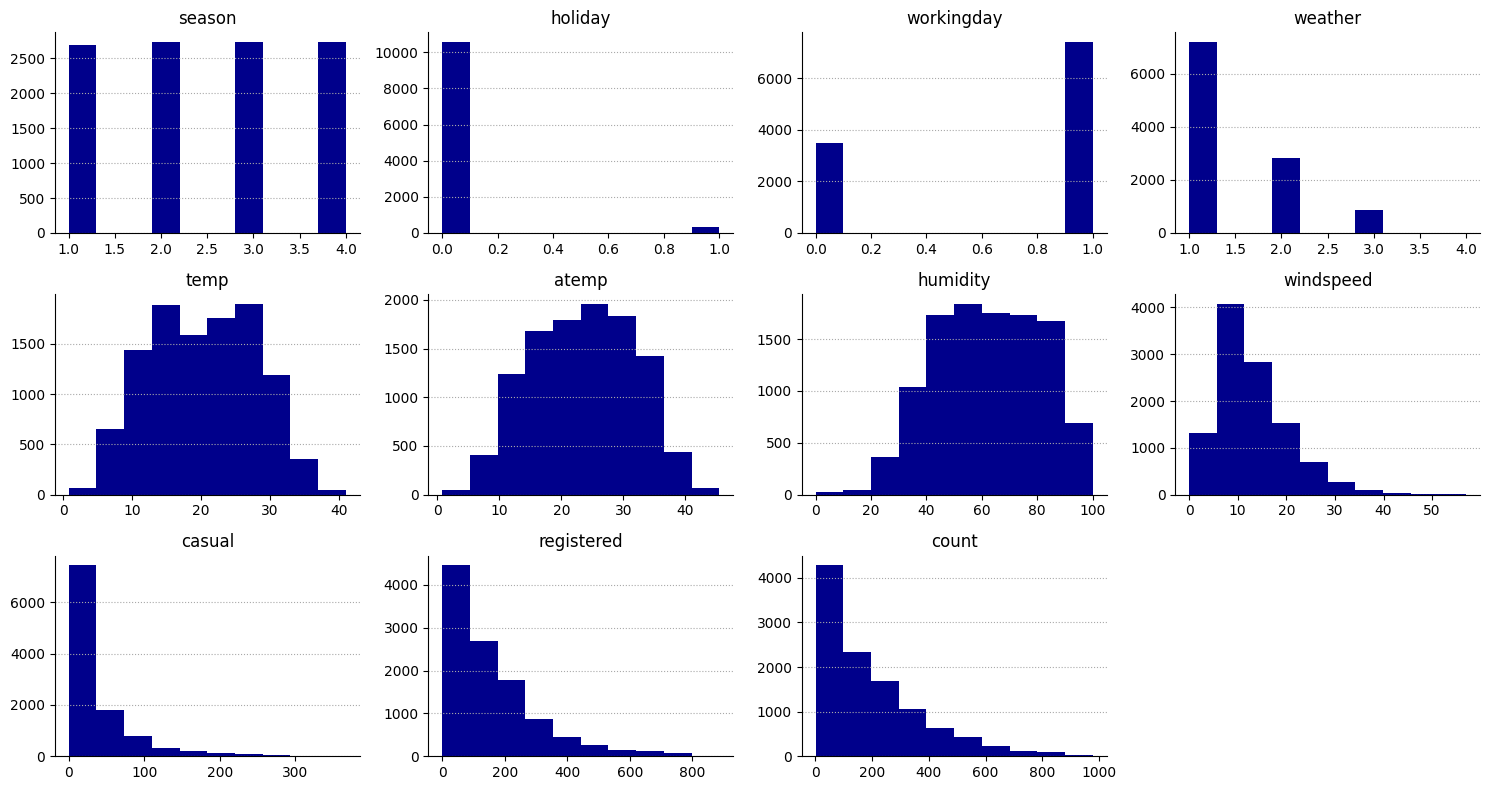

In [7]:
# 히스토그램 시각화
# 변수 선별
numeric_df = train_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(3, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> #### test 데이터

In [8]:
test_df.shape

(6493, 9)

In [9]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


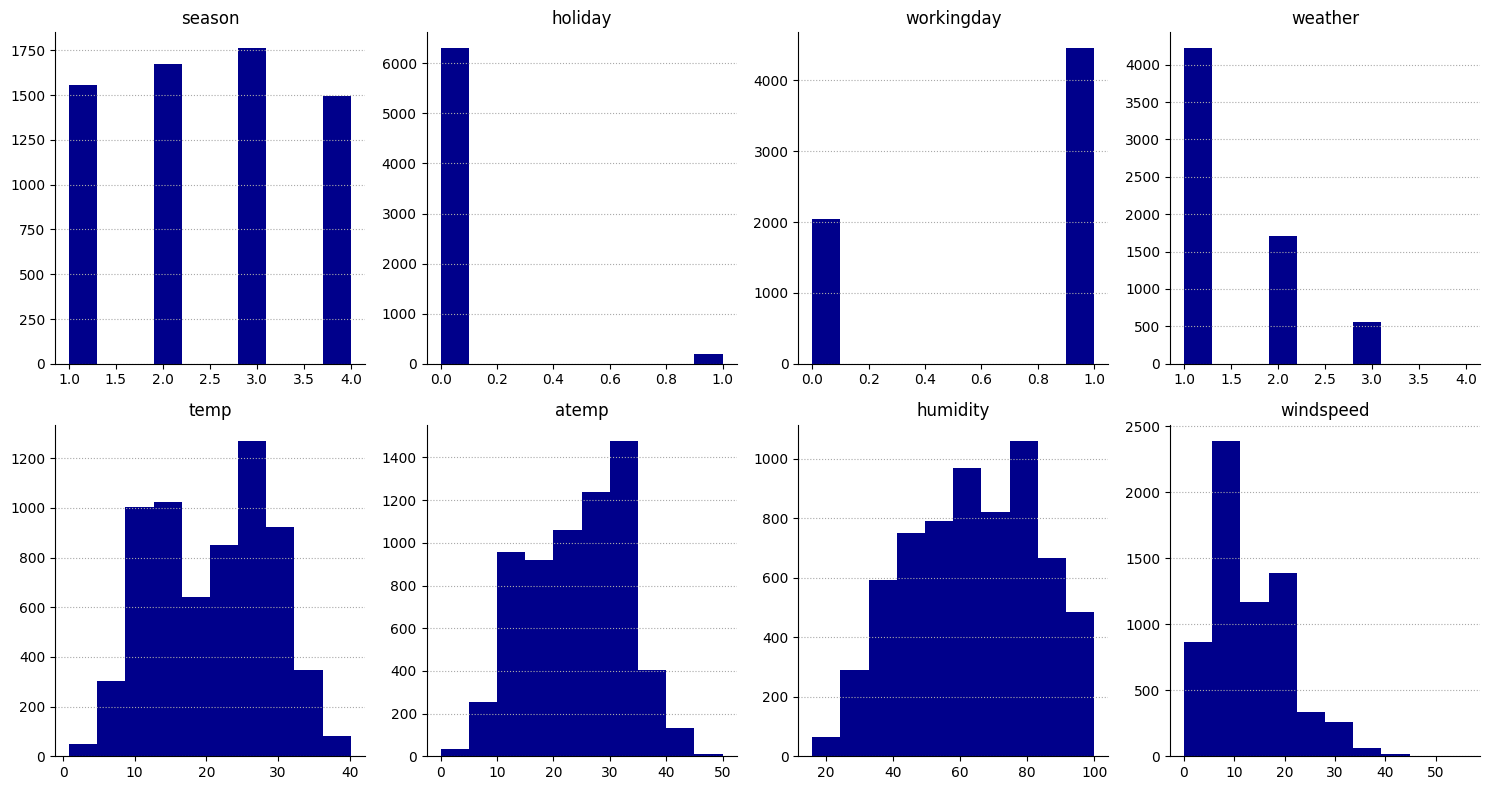

In [11]:
# 히스토그램 시각화
# 변수 선별
numeric_df = test_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()  

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

- train 데이터에는 `casual`, `registered`, `count` 컬럼 존재
- test 데이터에는 `casual`, `registered`, `count` 컬럼 존재하지 않는다.
- 따라서, 모델 훈련시에도 train데이터의 `casual`, `registered` feature는 제외해야한다.

#### 2) 상관관계 확인

- train 데이터 전체 변수간 상관관계 시각화

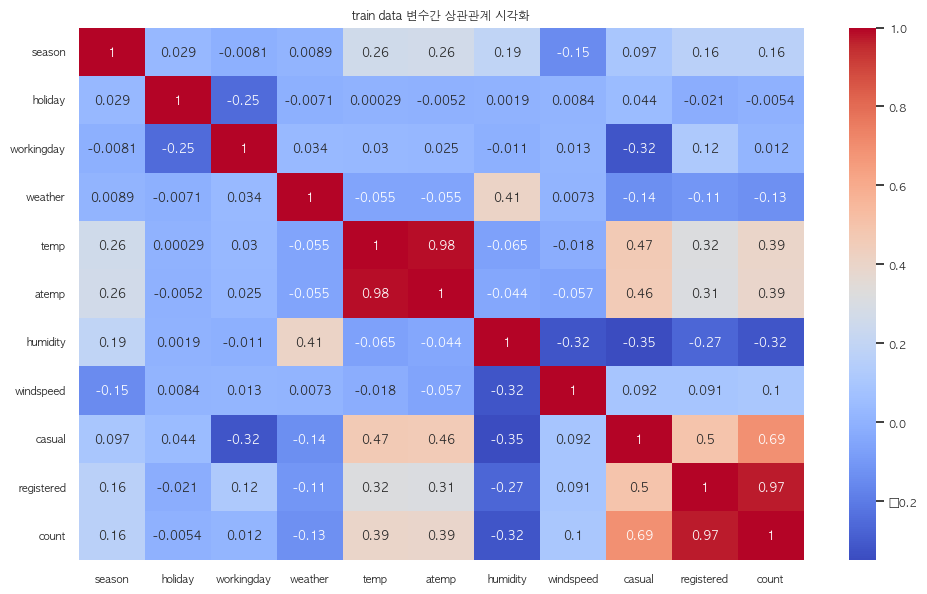

In [12]:
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr(), cbar=True, annot=True, cmap='coolwarm')

plt.title('train data 변수간 상관관계 시각화')
plt.tight_layout()
plt.show()

- 종속변수(`count`)와의 상관관계만 시각화

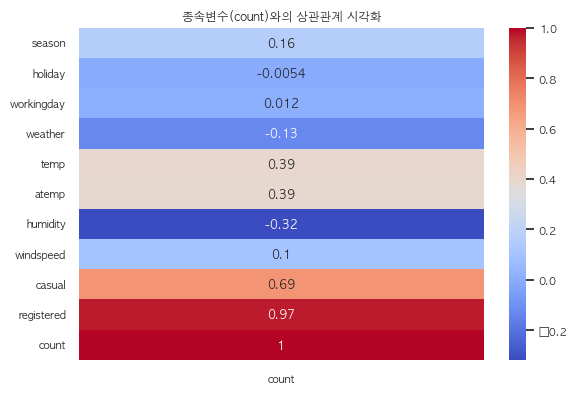

In [13]:
sns.set_theme(rc={'figure.figsize':(6,4)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=train_df.select_dtypes('number').corr()[['count']], cbar=True, annot=True, cmap='coolwarm')

plt.title('종속변수(count)와의 상관관계 시각화')
plt.tight_layout()
plt.show()

> 결과 요약
- count = casual + registered 이므로 당연히 `casual`, `registered` 두 변수와의 상관관계는 높다. 따라서 다중공선성 존재할 것이다.

- 양의 상관관계 : `windspeed`, `temp`, `atemp`, `workingday`, `season`
    - 비교적 큰 상관관계 : `temp`, `atemp`
    -  `temp`, `atemp`는 실측온도와 체감온도로, 두 변수는 거의 동일하므로 다중공선성 존재할 것이다.

- 음의 상관관계 : `holiday`, `weather`, `humidity`
    - 비교적 큰 상관관계 : `humidity`

#### 3) 시계열분석

- 대여수 관련 컬럼 casual, registered, count

In [18]:
train_df['month'] = train_df['datetime'].astype('datetime64[ns]').dt.strftime('%Y-%m')
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01


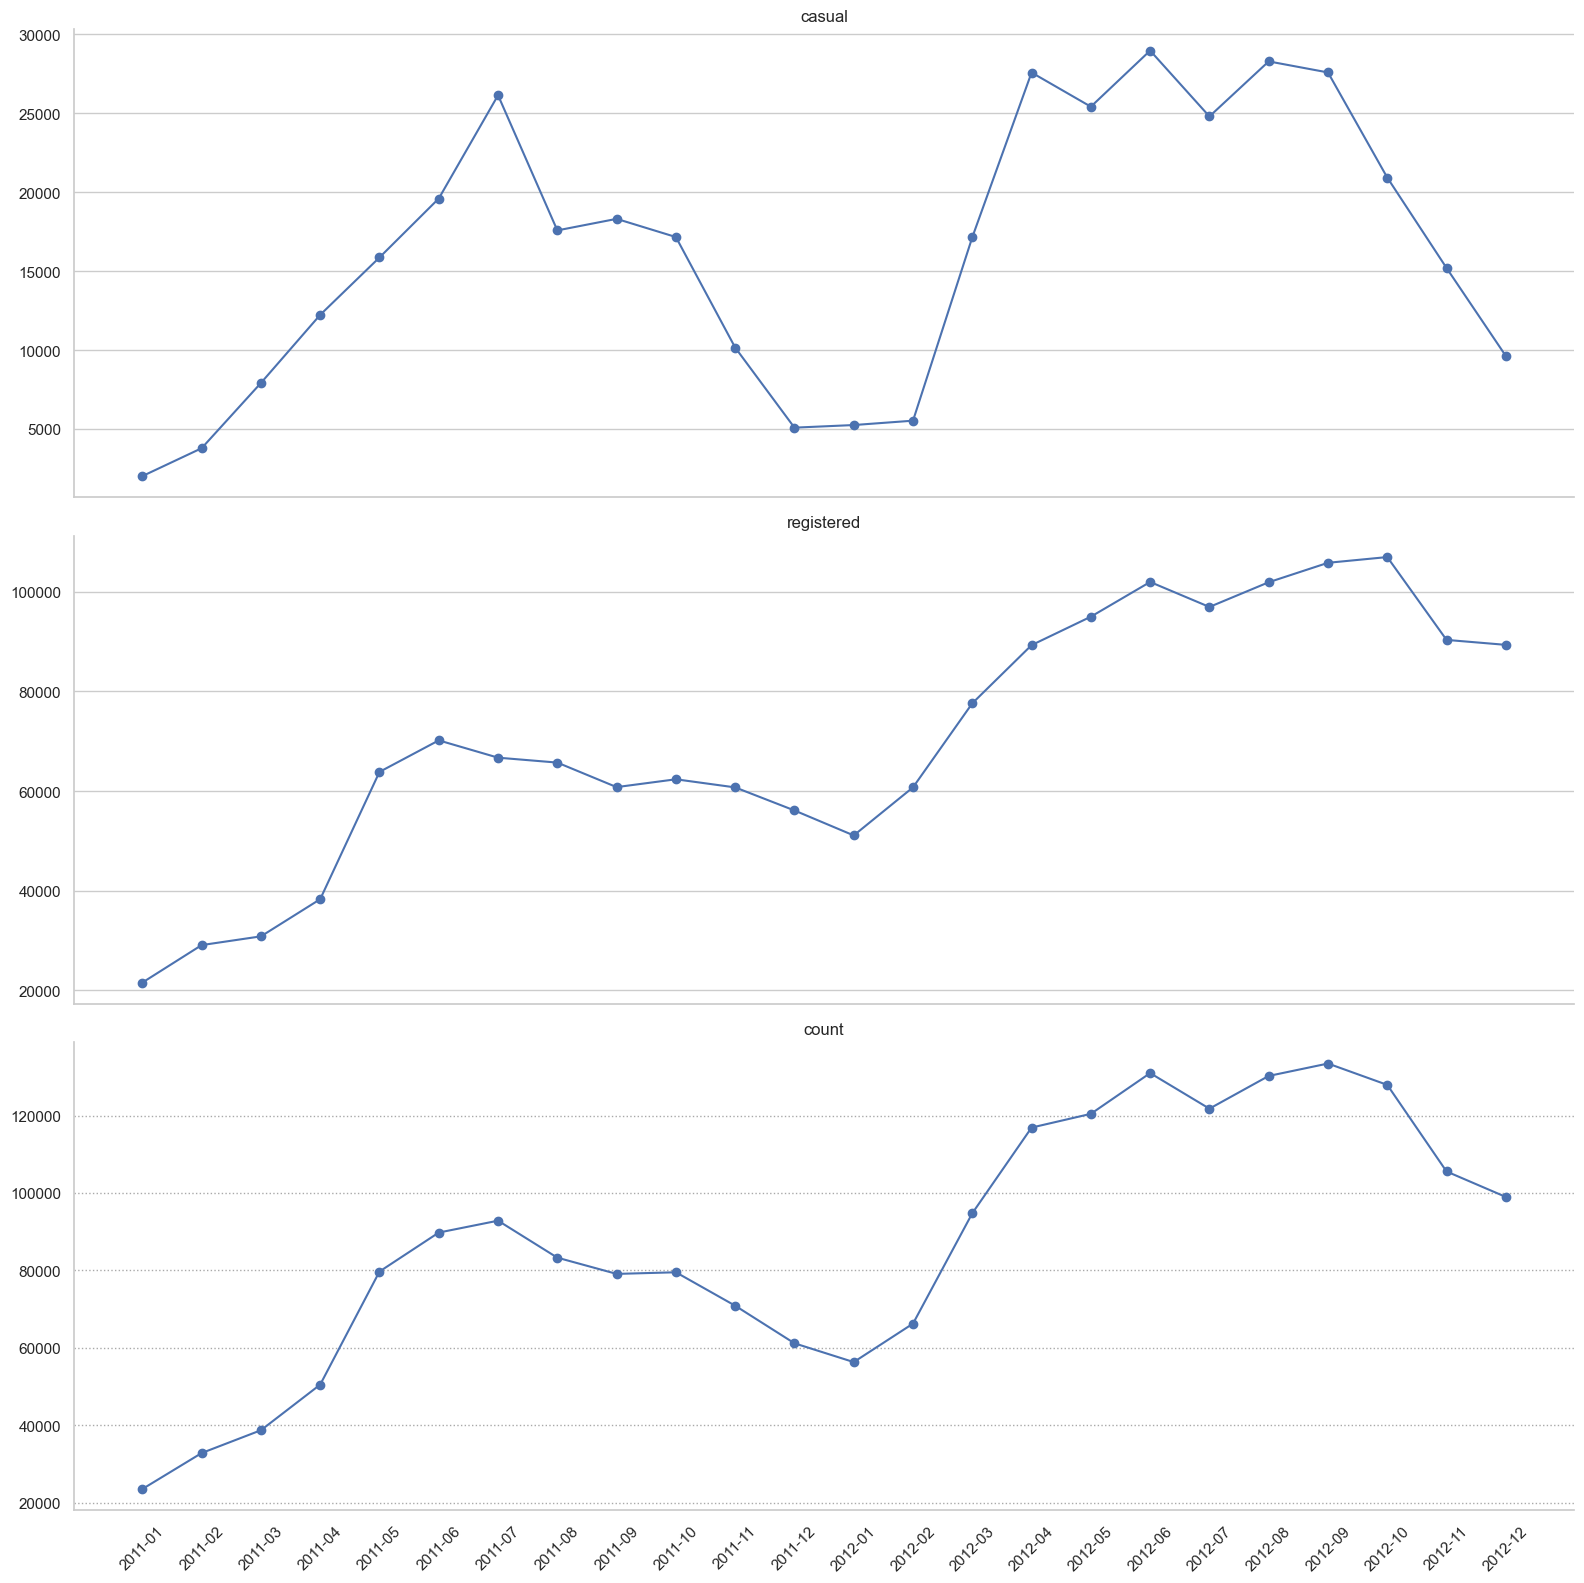

In [21]:
# 서브플롯 생성
fig, axes = plt.subplots(3, 1, figsize=(16, 16))
axes = axes.flatten()
cols = ['casual','registered', 'count']


# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    sns.set_theme(style='whitegrid')
    month_df = train_df[['month', column]].groupby('month').sum()[column].reset_index()

    axes[i].plot(month_df.reset_index()['month'], month_df.reset_index()[column], marker='o')
    axes[i].set_title(column)
 
    if i == len(cols) - 1:
        axes[i].set_xticks(month_df['month'])
        axes[i].set_xticklabels(month_df['month'], rotation=45)
        axes[i].grid(False)
        axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    else:
        axes[i].set_xticks([])
        axes[i].grid(axis='x', linestyle=':', color='darkgrey')
 
    #axes[i].set_ylim(bottom=0)
    axes[i].spines[['top','right']].set_visible(False)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 총 대여수, 총 회원 대여수, 총 비회원 대여수 추이가 거의 동일하고, 2~4월에 증가했다가 10월까지 유지되고 이후 감소하는 패턴이 2년간 동일하게 관찰

- temp,atemp, humidity, windspeed

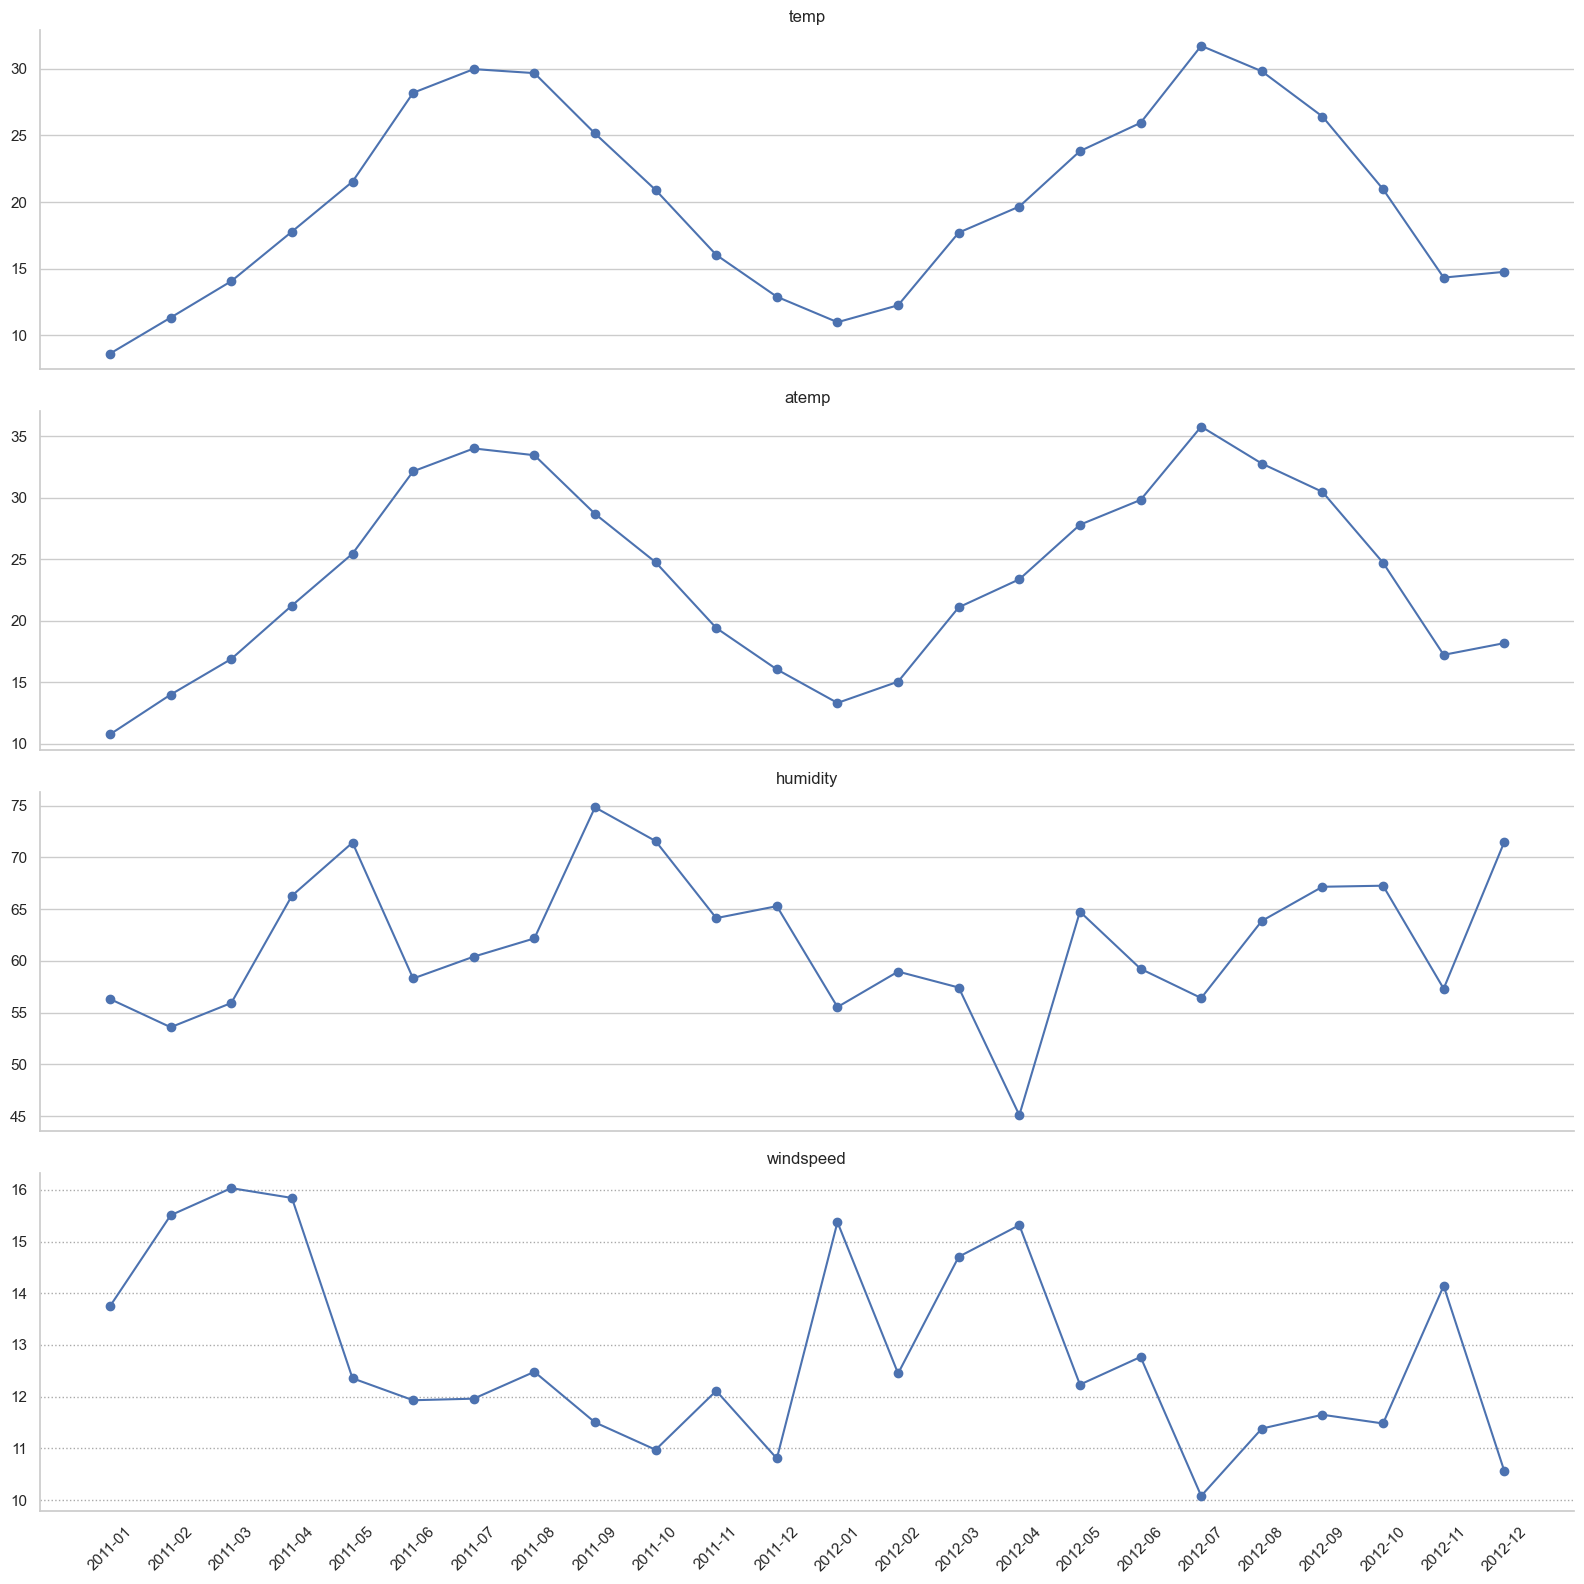

In [22]:
# 서브플롯 생성
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
axes = axes.flatten()
cols = ['temp','atemp', 'humidity', 'windspeed']

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    sns.set_theme(style='whitegrid')
    month_df = train_df[['month', column]].groupby('month').mean()[column].reset_index()

    axes[i].plot(month_df.reset_index()['month'], month_df.reset_index()[column], marker='o')
    axes[i].set_title(column)
 
    if i == len(cols) - 1:
        axes[i].set_xticks(month_df['month'])
        axes[i].set_xticklabels(month_df['month'], rotation=45)
        axes[i].grid(False)
        axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    else:
        axes[i].set_xticks([])
        axes[i].grid(axis='x', linestyle=':', color='darkgrey')
 
    #axes[i].set_ylim(bottom=0)
    axes[i].spines[['top','right']].set_visible(False)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

- 각 변수의 추이와 총 대여수인 count 추이를 비교해보면 앞선 count와의 상관관계 분석 결과를 지지한다는 사실을 알 수 있다.
- temp, atemp와 비례, humidity와 windspeed 반비례

### 결측값 처리

In [23]:
# 컬럼별 결측값 확인
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
month         0
dtype: int64

### 중복값 처리

In [24]:
# 중복값 확인
train_df.duplicated().sum()

np.int64(0)

### 이상치 처리

In [25]:
numeric_cols = list(train_df.select_dtypes('number').columns)

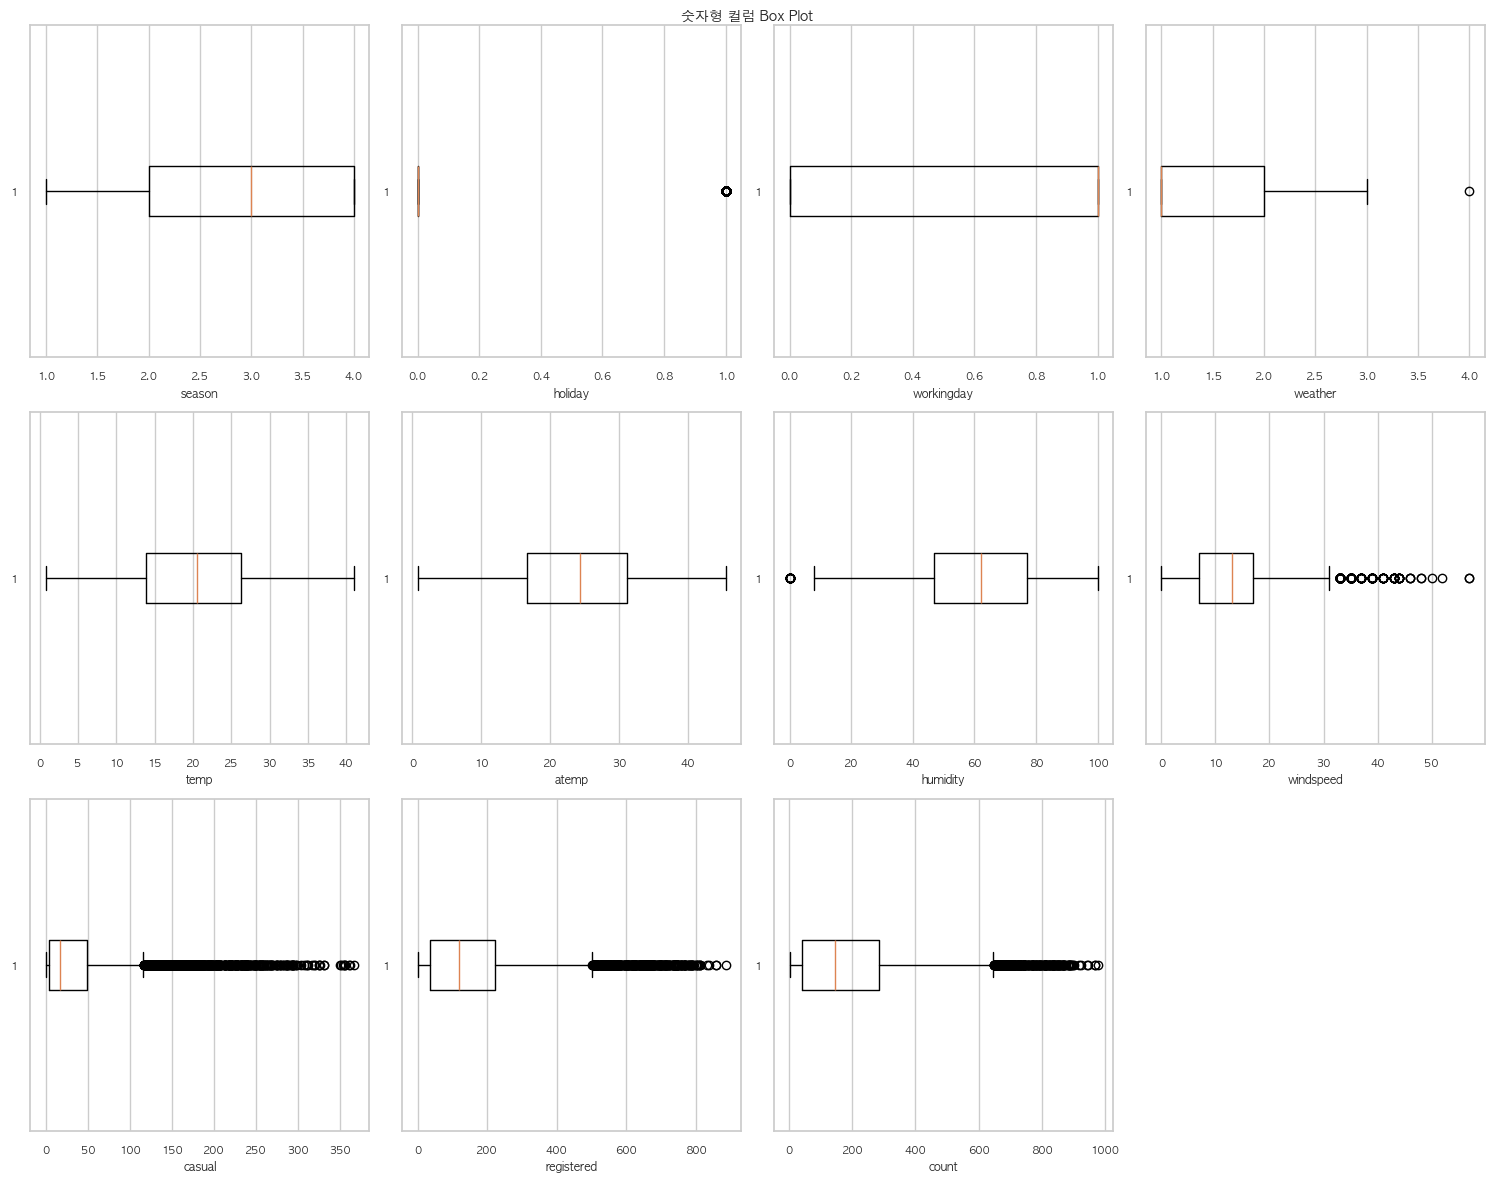

In [26]:
# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font='AppleGothic', font_scale=0.7)

fig, axes = plt.subplots(3,4,figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].boxplot(train_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('숫자형 컬럼 Box Plot')

fig.tight_layout()
fig.show()

> 결과 요약
- `season`, `workingday`, `hoilday`는 범주형 변수이므로 이상치를 처리하지 않는다.
- 대여 수를 나타내는 `casual`, `registered`, `count` 컬럼에서 이상치가 주로 발생
- max값과 min값 확인하여 이상치 처리 판단

In [27]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


- 대여수 관련하여 앞서 진행했던 시계열분석 결과를 참고하여 대여수 관련 이상치가 납득이 되는 합리적인 값인지 판단

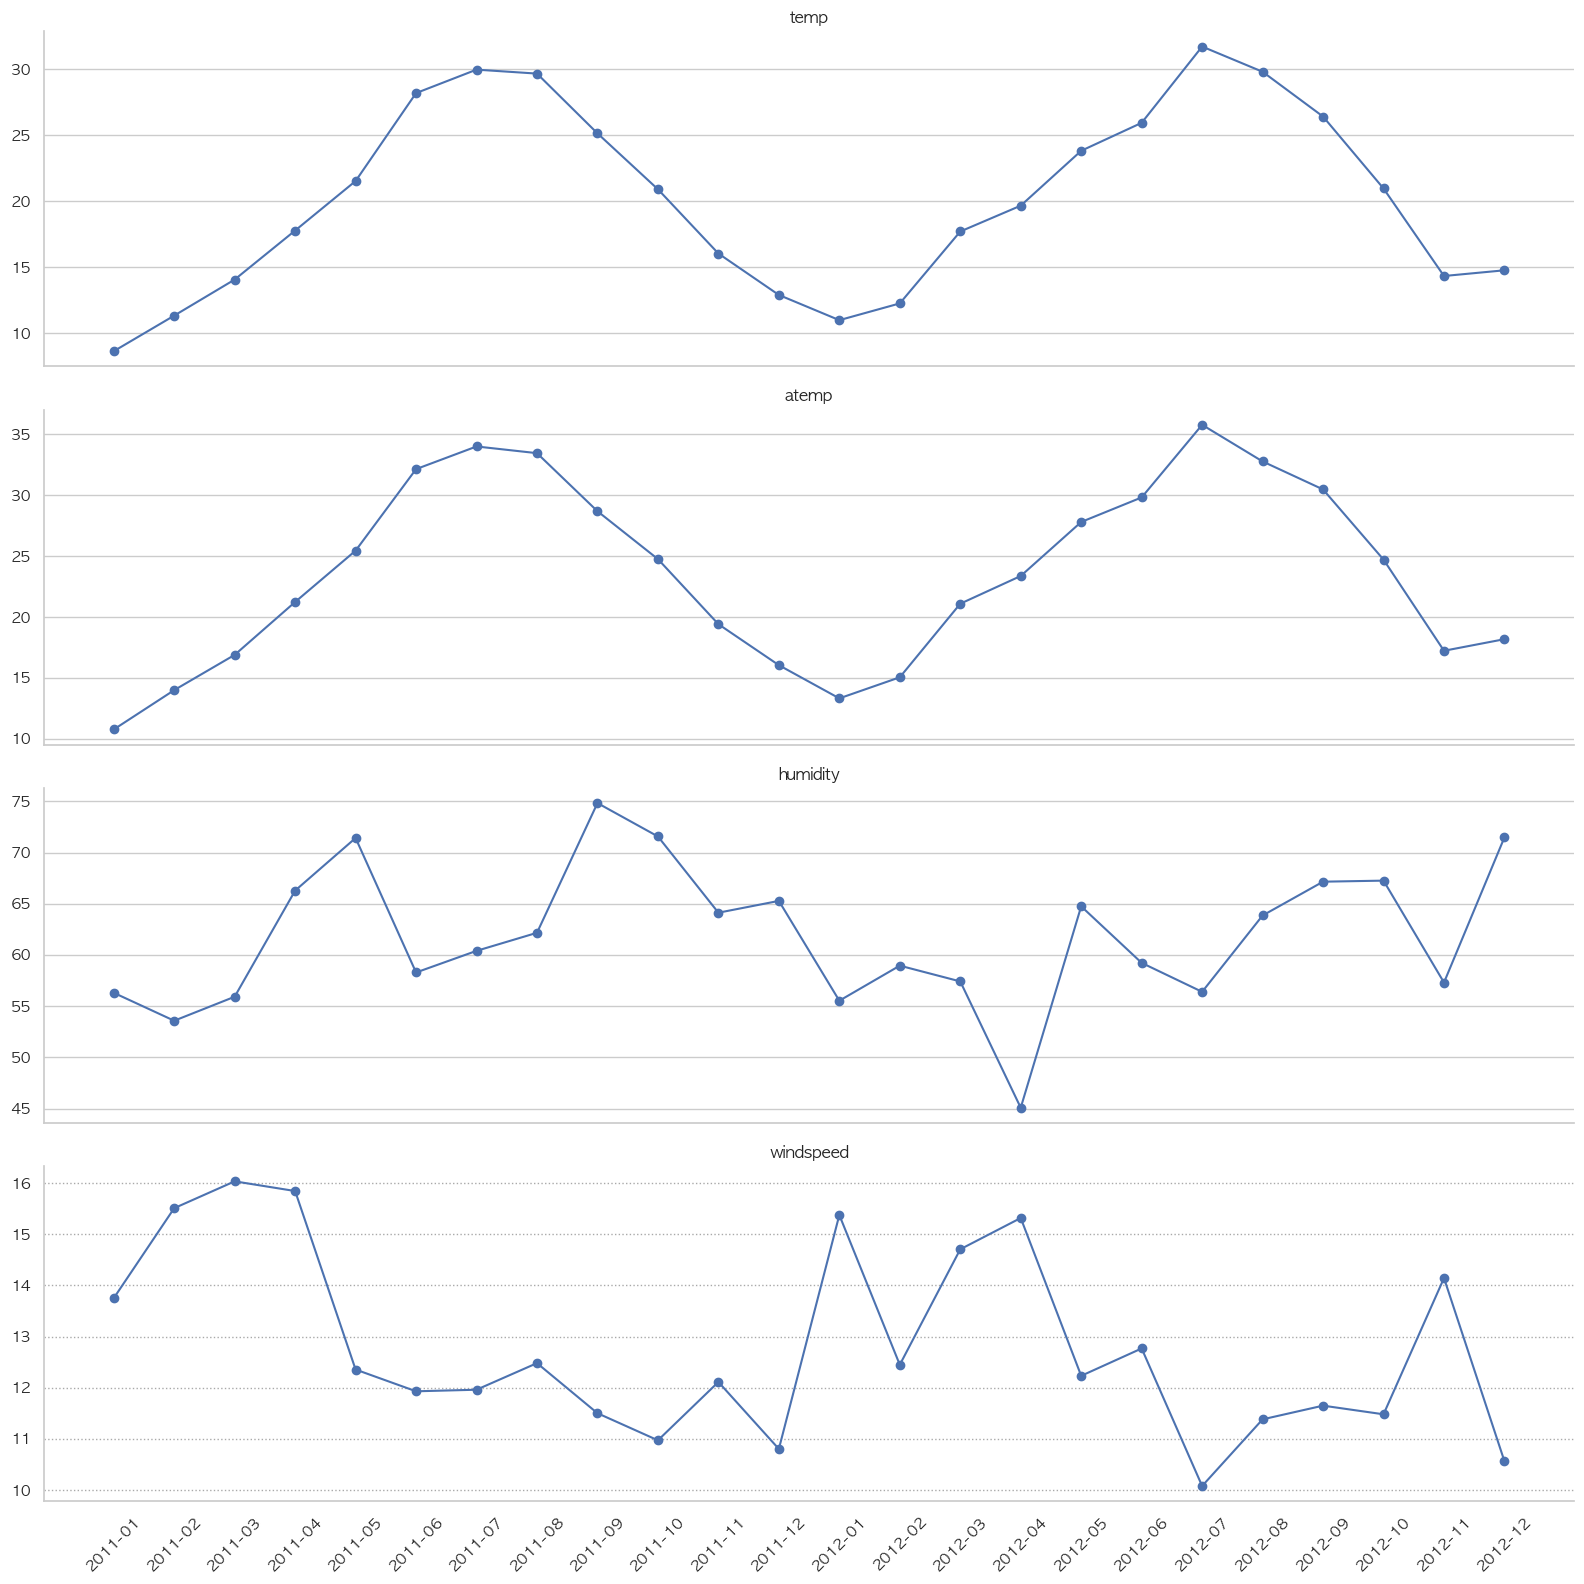

> #### 결론
> - 총 대여수, 총 회원 대여수, 총 비회원 대여수 추이가 거의 동일하고, 2~4월에 증가했다가 10월까지 유지되고 이후 감소하는 패턴이 2년간 동일하게 관찰되므로 서비스의 성장으로 인한 수치의 증가로 간주하고 이상치라고 판단하지 않는다.
> - 대여수 관련 컬럼 제외하고 이상치를 제거한다.

- 이상치 처리 진행

In [28]:
# 이상치 처리할 컬럼 선별
remove_cols = ['temp','atemp','humidity','windspeed']
remove_cols

['temp', 'atemp', 'humidity', 'windspeed']

In [75]:
# 이상치 처리 함수 정의
def remove_out(dataframe, remove_cols):
    for col in remove_cols:
        q1 = dataframe[col].quantile(0.25)
        q3 = dataframe[col].quantile(0.75)
        iqr = q3-q1
        dataframe = dataframe[(dataframe[col] >= (q1 - (1.5*iqr)))&(dataframe[col] <= (q3 + (1.5*iqr)))]
    return dataframe

# 이상치 제거
preprocessed_df = remove_out(train_df, remove_cols)
preprocessed_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12


In [76]:
# 10886 > 10638 (248개의 이상치 제거)
preprocessed_df.shape

(10638, 13)

### 표준화
- 독립변수 중 수치형 변수간 스케일 차이가 크게 나므로 표준화를 실시한다.
- 다항회귀를 위한 표준화는 다항회귀를 진행할 때 다항회귀 데이터로 변환한 후 표준화를 따로 진행하기로 한다.
- Test 데이터에는 casual, regitstered 컬럼이 존재하지 않으므로, Training 데이터에서도 제외하고 모델을 학습시킨다.

In [77]:
# 표준화를 위한 데이터 프레임 복제
standardaized_df = preprocessed_df.copy()

# 표준화 모델 생성
scaler = StandardScaler()
cols = ['temp', 'atemp','humidity','windspeed']

# 표준화 모델 적용
standardaized_df[cols] = scaler.fit_transform(standardaized_df[cols])
standardaized_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,5,27,32,2011-01


In [78]:
# 표준화 확인
standardaized_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10638.000000,10638.000000,10638.000000,10638.000000,1.063800e+04,1.063800e+04,1.063800e+04,1.063800e+04,10638.000000,10638.000000,10638.000000
mean,2.525005,0.028671,0.680015,1.414176,1.816767e-16,-2.137372e-17,6.946460e-17,2.190807e-16,36.087610,155.795074,191.882685
std,1.112496,0.166887,0.466492,0.628156,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,49.987538,151.139015,181.238751
min,1.000000,0.000000,0.000000,1.000000,-2.496810e+00,-2.718063e+00,-2.874980e+00,-1.650509e+00,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,-8.132460e-01,-8.354000e-01,-8.114904e-01,-7.098007e-01,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,2.853616e-02,6.124719e-02,-1.784058e-02,-1.723814e-01,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,7.650956e-01,8.685256e-01,8.287192e-01,6.332974e-01,49.000000,223.000000,285.000000
max,4.000000,1.000000,1.000000,4.000000,2.659106e+00,2.572451e+00,1.992739e+00,2.514715e+00,367.000000,886.000000,977.000000


---

## 예측 모델 개발

### Feature Engineering

#### 1) 시간대 매핑
- 워크타임전 : 0시 ~ 8시 $\rightarrow$ 0
- 워크타임 : 9시 ~ 17시 $\rightarrow$ 1
- 워크타임후 : 18시 ~ 24시 $\rightarrow$ 2

In [79]:
standardaized_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0,1,1,2011-01


In [80]:
# 데이터 프레임 복사
feature_engineered_df = standardaized_df.copy()
feature_engineered_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0,1,1,2011-01


In [81]:
# datetime 컬럼 datetime형식으로 변환(object > datetime)
feature_engineered_df['datetime'] = feature_engineered_df['datetime'].astype('datetime64[ns]')

In [82]:
# 시간대 time 컬럼 생성
feature_engineered_df['time'] = feature_engineered_df['datetime'].apply(lambda x : x.hour)
feature_engineered_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time
0,2011-01-01 00:00:00,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,3,13,16,2011-01,0
1,2011-01-01 01:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,8,32,40,2011-01,1
2,2011-01-01 02:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,5,27,32,2011-01,2
3,2011-01-01 03:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,3,10,13,2011-01,3
4,2011-01-01 04:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0,1,1,2011-01,4


In [83]:
# 시간대 매핑
feature_engineered_df['time'] = feature_engineered_df['time'].apply(lambda x : 0 if x >= 0 and x <= 7 else
                                                                        1 if x >= 8 and x <= 15 else
                                                                        2 if x >= 16 and x<=23 else None)

feature_engineered_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time
0,2011-01-01 00:00:00,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,3,13,16,2011-01,0
1,2011-01-01 01:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,8,32,40,2011-01,0
2,2011-01-01 02:00:00,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,5,27,32,2011-01,0
3,2011-01-01 03:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,3,10,13,2011-01,0
4,2011-01-01 04:00:00,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0,1,1,2011-01,0


In [84]:
# 매핑 확인
feature_engineered_df['time'].value_counts()

time
0    3559
2    3548
1    3531
Name: count, dtype: int64

##### 독립변수(X) / 종속변수(y) 분할

- Test 데이터 셋에 대여 관련 컬럼들(casual, registered, count)이 없기 때문에 모델 학습시에도 제외해준다.

In [85]:
# 변수 나눔
X = feature_engineered_df.drop(['datetime','month','casual','registered','count'], axis=1)
y = feature_engineered_df[['count']]

In [86]:
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,time
0,1,0,0,1,-1.339360,-1.104098,0.987449,-1.650509,0
1,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,0
2,1,0,0,1,-1.444583,-1.194059,0.934539,-1.650509,0
3,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0
4,1,0,0,1,-1.339360,-1.104098,0.669989,-1.650509,0
...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,-0.602800,-0.476741,-0.652760,1.843166,2
10882,4,0,1,1,-0.708023,-0.745439,-0.282391,0.365038,2
10883,4,0,1,1,-0.813246,-0.924769,-0.070751,0.365038,2
10884,4,0,1,1,-0.813246,-0.745439,-0.070751,-0.843930,2


In [87]:
X.shape

(10638, 9)

In [88]:
y

,count
0,16
1,40
2,32
3,13
4,1
...,...
10881,336
10882,241
10883,168
10884,129


In [89]:
y.shape

(10638, 1)

#### 2) 범주형 변수 one-hot encoding

In [90]:
# One-hot Encoding을 특정 열에만 적용
X = pd.get_dummies(X, columns=['season', 'holiday','workingday','weather','time'], drop_first=True, dtype=int) # 다중공선성 문제를 피하기 위해 첫번째 열을 삭제

# 결과 확인
X.head()

,temp,atemp,humidity,windspeed,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,time_1,time_2
0,-1.339360,-1.104098,0.987449,-1.650509,0,0,0,0,0,0,0,0,0,0
1,-1.444583,-1.194059,0.934539,-1.650509,0,0,0,0,0,0,0,0,0,0
2,-1.444583,-1.194059,0.934539,-1.650509,0,0,0,0,0,0,0,0,0,0
3,-1.339360,-1.104098,0.669989,-1.650509,0,0,0,0,0,0,0,0,0,0
4,-1.339360,-1.104098,0.669989,-1.650509,0,0,0,0,0,0,0,0,0,0


### 회귀 모델 실험

#### 1) 다중 선형 회귀

In [105]:
# training set, test set 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# 각 데이터 프레임의 모양 확인
print(f'X_train : {X_train.shape}')  
print(f'X_test : {X_test.shape}')   
print(f'y_train : {y_train.shape}')  
print(f'y_test : {y_test.shape}')

X_train : (8510, 14)
X_test : (2128, 14)
y_train : (8510, 1)
y_test : (2128, 1)


In [106]:
# 모델 학습 및 적용
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [107]:
# 학습된 θ 값 확인
print(model.coef_)      
print(model.intercept_)

[[ 52.07910725   6.20087173 -29.06699699  -0.63452482  26.22986535
    8.57567859  67.00627567 -13.01472313  -1.91756394   2.48696837
  -41.30142193  54.34959041 149.06680876 173.28815062]]
[63.91903518]


In [108]:
# 학습 모델로 예측 성능 평가
y_test_prediction = model.predict(X_test)

# 평균 제곱근 오차(RMSE) 계산
mse = mean_squared_error(y_test, y_test_prediction)
rmse = mse ** 0.5
print(f"평균 제곱근 오차: {rmse:.2f}")

평균 제곱근 오차: 137.36


In [117]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b

# y는 log1p 변환값 (log1p : log(1+x))

rmsle_lr = rmsle(y_test, y_test_prediction, convertExp=False)
print("RMSLE:", rmsle_lr)

RMSLE: 1.049575211166342


- RMSE가 약 `137`, RMSLE가 약 `1.05`로 산출되었으므로 성능이 좋지않다고 판단된다.

#### 2) 다항 회귀(Lasso)

- 다항회귀 모델을 통해 고차항으로 만들면 새롭게 생성되는 고차항의 Feature간 스케일 차이가 발생하므로 표준화 과정을 무조건 해줘야하기 때문에 표준화 전 데이터를 다시 가져와서 가공한다. (표준화를 2번 진행하면 원본 데이터 특성이 지나치게 희석되므로)

In [121]:
preprocessed_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01


In [122]:
# 데이터 프레임 복사
feature_engineered_df = preprocessed_df.copy()
feature_engineered_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01


In [123]:
# datetime 컬럼 datetime형식으로 변환(object > datetime)
feature_engineered_df['datetime'] = feature_engineered_df['datetime'].astype('datetime64[ns]')

# 시간대 time 컬럼 생성
feature_engineered_df['time'] = feature_engineered_df['datetime'].apply(lambda x : x.hour)

# 시간대 매핑
feature_engineered_df['time'] = feature_engineered_df['time'].apply(lambda x : 0 if x >= 0 and x <= 7 else
                                                                        1 if x >= 8 and x <= 15 else
                                                                        2 if x >= 16 and x<=23 else None)

feature_engineered_df.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01,0


In [124]:
# 매핑 확인
feature_engineered_df['time'].value_counts()

time
0    3559
2    3548
1    3531
Name: count, dtype: int64

- 독립/종속 변수 분할

In [125]:
# 변수 나눔
X = feature_engineered_df.drop(['datetime','month','casual','registered','count'], axis=1)
y = feature_engineered_df[['count']]

print(f'독립변수 크기: {X.shape}')
print(f'종속변수 크기: {y.shape}')

독립변수 크기: (10638, 9)
종속변수 크기: (10638, 1)


##### 2차항

In [126]:
# 2차 다항 회귀 변형기 정의
poly = PolynomialFeatures(degree=2)

# 변형기를 통해 입력 데이터를 6차 항으로 변환
X_poly = poly.fit_transform(X)

# StandardScaler로 데이터를 표준화 (Standardization)
scaler = StandardScaler()

# 변환된 다항 회귀 데이터를 표준화
X_poly_scaled = scaler.fit_transform(X_poly)

# 훈련/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [ ]:
# 하이퍼파라미터 딕셔너리 설정
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000, 1500, 2000]
}

In [ ]:
# Lasso 모델 정의
lasso_model = Lasso() # 파라미터를 안정함.

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5)

# 그리드 서치 실행
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'max_iter': [100, 500, 1000, 1500, 2000]})

In [ ]:
# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'alpha': 0.01, 'max_iter': 100}


In [129]:
# 모델 학습
lasso_model = Lasso(alpha=0.001, max_iter=1000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.001)

In [98]:
# 트레이닝 셋과 테스트 셋에서 예측값 계산
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# 각각의 성능을 평가 (평균 제곱근 오차 계산)
bias = np.sqrt(mean_squared_error(y_train, y_train_pred))
variance = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 결과 출력
print(f'Training RMSE: {bias}')
print(f'Test RMSE: {variance}')
print(f'적합 : variance의가 bias보다 약 {round(variance/bias)} 배 크다')

#### 3) 다항 회귀(Lidge)

# BACK UP

## EDA

### 1) 기술통계분석

In [ ]:
preprocessed_df.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
count,10638,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638.000000,10638
unique,10638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24
top,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-12
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454
mean,NaN,2.525005,0.028671,0.680015,1.414176,20.277618,23.722575,62.337187,12.284399,36.087610,155.795074,191.882685,NaN
std,NaN,1.112496,0.166887,0.466492,0.628156,7.793356,8.448536,18.900912,7.443142,49.987538,151.139015,181.238751,NaN
min,NaN,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,8.000000,0.000000,0.000000,0.000000,1.000000,NaN
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,NaN
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,11.001400,17.000000,118.000000,145.000000,NaN
75%,NaN,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,78.000000,16.997900,49.000000,223.000000,285.000000,NaN


### 2) 상관관계 분석

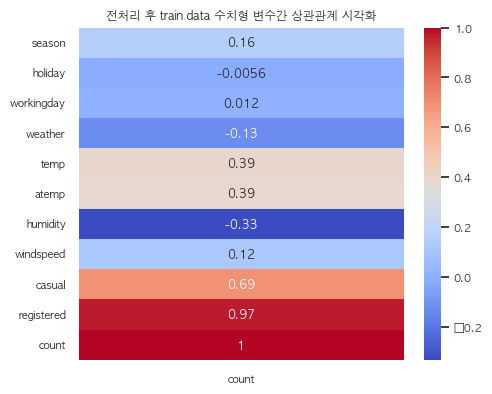

In [ ]:
# 상관관계 시각화
sns.set_theme(style='white',rc={'figure.figsize':(5,4)}, font='AppleGothic', font_scale=0.7)
sns.heatmap(data=preprocessed_df.select_dtypes('number').corr()[['count']], cbar=True, annot=True, cmap='coolwarm')

plt.title('전처리 후 train data 수치형 변수간 상관관계 시각화')
plt.tight_layout()
plt.show()

- 종속변수 count와의 상관관계 분석
    - 양의 상관관계 : `temp`, `atemp`, season, windspeed, workingday
    - 음의 상관관계 : `humidity`, `weather`, hoilday

### 3) 시계열분석

#### count

- count 컬럼은 전처리 하지 않았으므로 위에서 살펴본 시계열분석과 동일

In [ ]:
preprocessed_df.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01


In [ ]:
# 월별 총 대여수 테이블 생성
month_df = preprocessed_df.groupby('month').sum()[['count']].reset_index()
month_df

,month,count
0,2011-01,23128
1,2011-02,28945
2,2011-03,37128
3,2011-04,46243
4,2011-05,78804
5,2011-06,88740
6,2011-07,92133
7,2011-08,81846
8,2011-09,78796
9,2011-10,78154


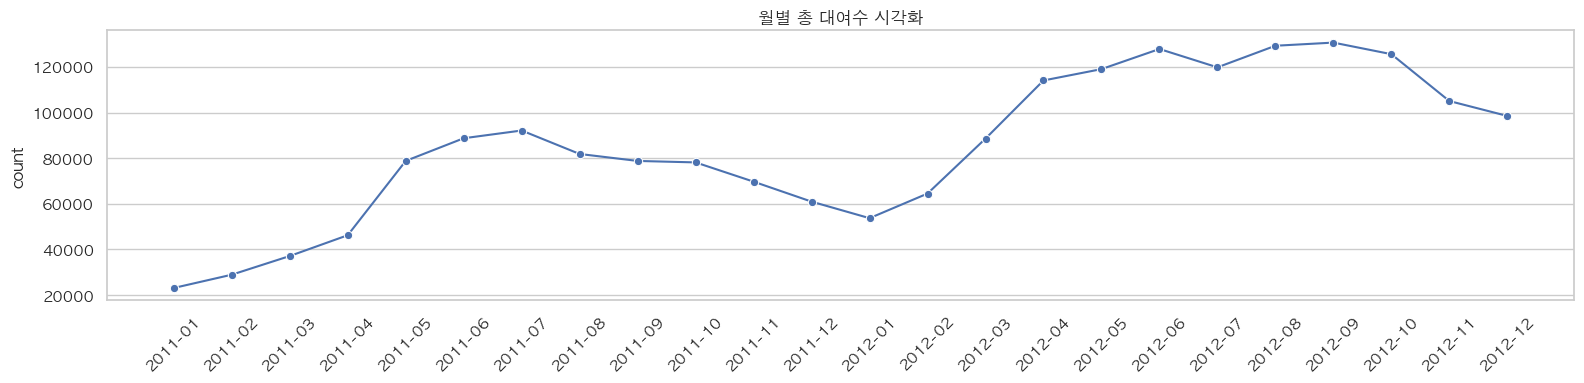

In [ ]:
# 전처리 이후 종속변수 count의 시계열 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(16,4)},font='AppleGothic')
sns.lineplot(month_df.reset_index(),x='month', y='count', marker='o')


plt.title('월별 총 대여수 시각화')
plt.grid(axis='x')
plt.xticks(rotation=45)
plt.xlabel('')
plt.tight_layout()
plt.show()

#### count

In [ ]:
preprocessed_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'month'],
      dtype='object')

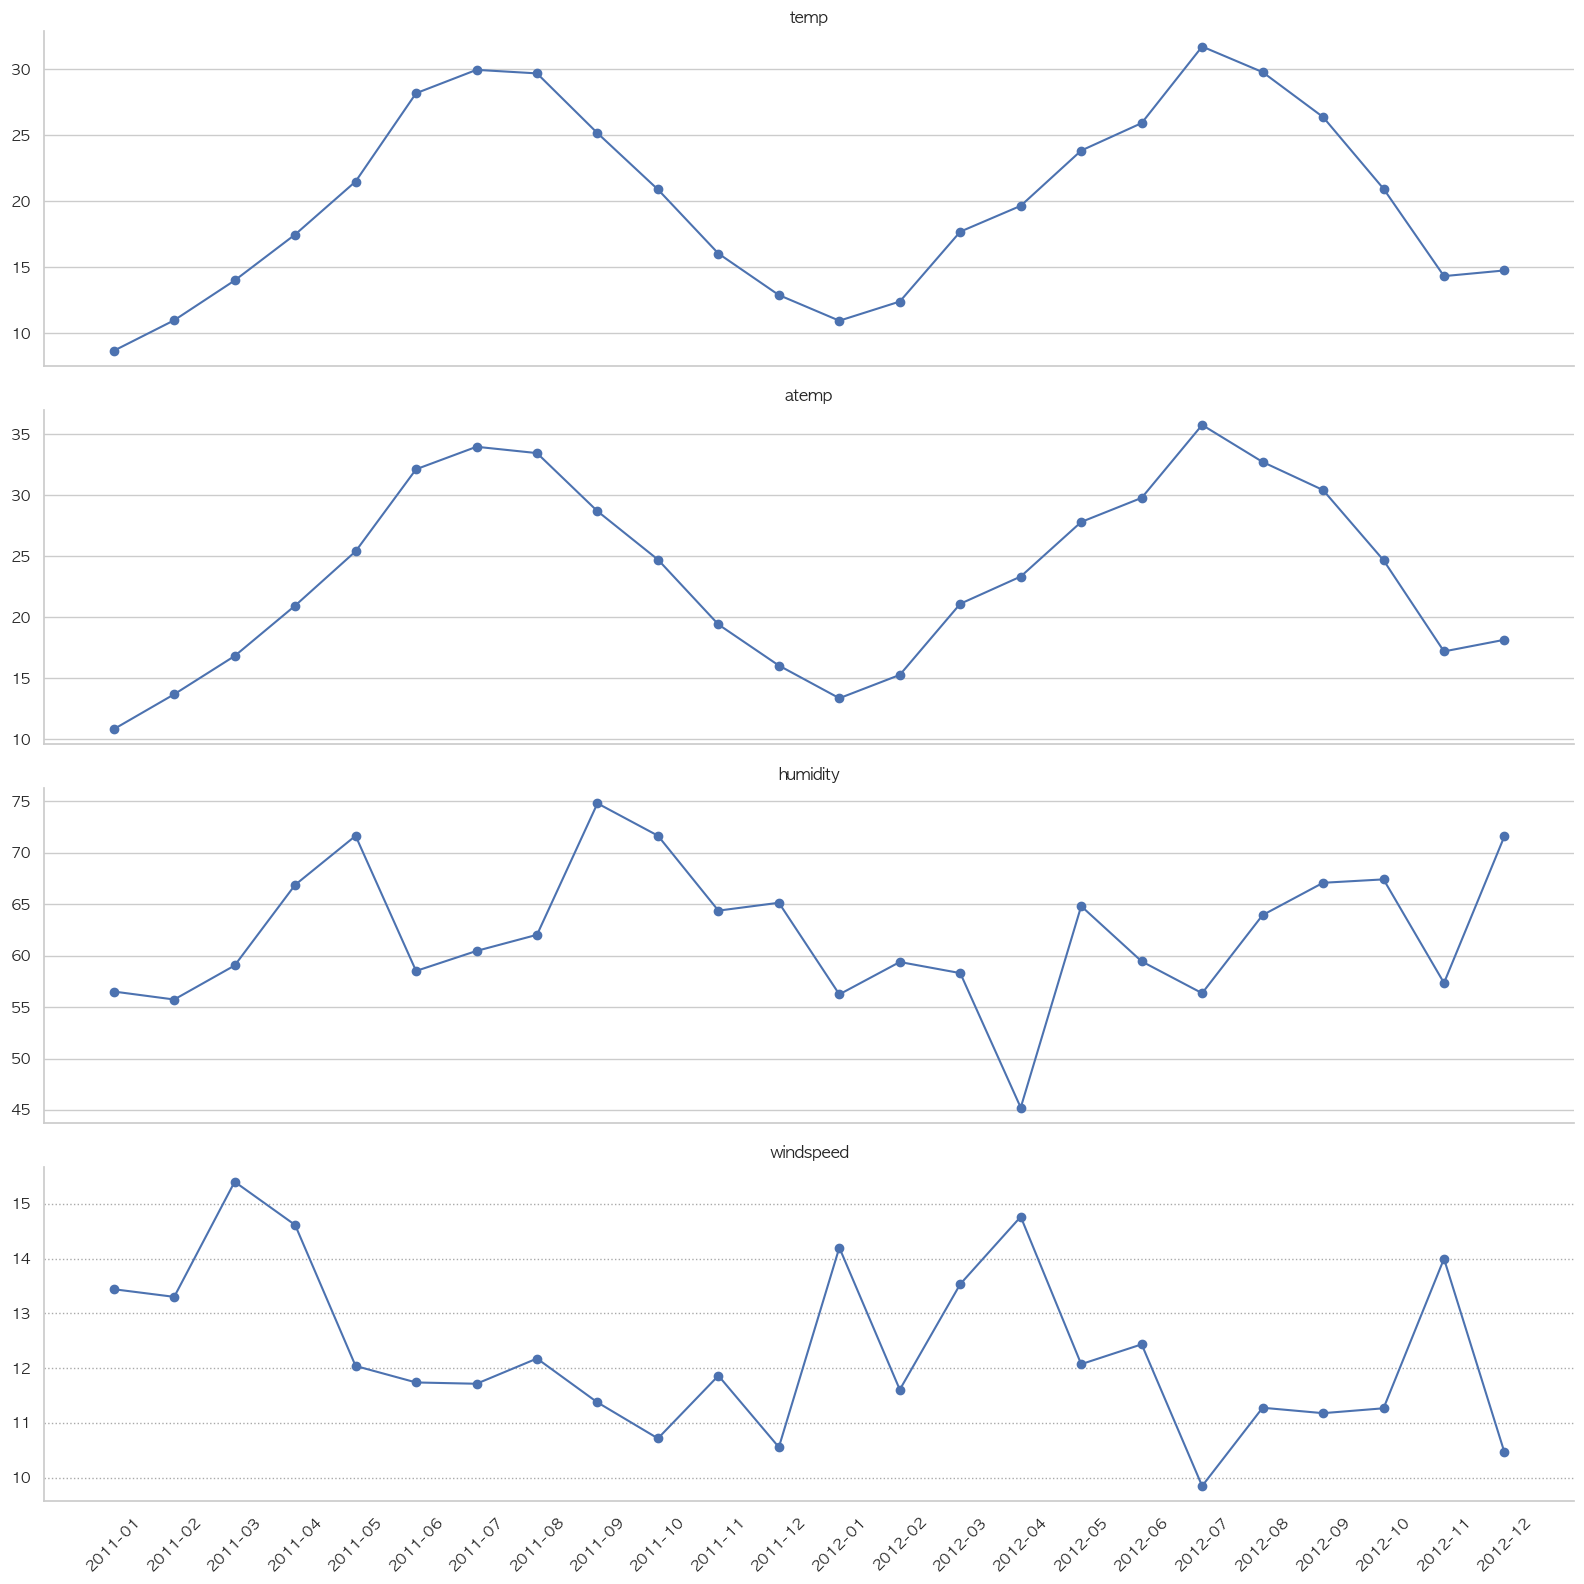

In [ ]:
# 서브플롯 생성
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
axes = axes.flatten()
cols = ['temp','atemp', 'humidity', 'windspeed']

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    month_df = preprocessed_df[['month', column]].groupby('month').mean()[column].reset_index()

    axes[i].plot(month_df.reset_index()['month'], month_df.reset_index()[column], marker='o')
    axes[i].set_title(column)
 
    if i == len(cols) - 1:
        axes[i].set_xticks(month_df['month'])
        axes[i].set_xticklabels(month_df['month'], rotation=45)
        axes[i].grid(False)
        axes[i].grid(axis='y', linestyle=':', color='darkgrey')
    else:
        axes[i].set_xticks([])
        axes[i].grid(axis='x', linestyle=':', color='darkgrey')
 
    #axes[i].set_ylim(bottom=0)
    axes[i].spines[['top','right']].set_visible(False)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

- 각 변수의 추이와 총 대여수인 count 추이를 비교해보면 앞선 count와의 상관관계 분석 결과를 지지한다는 사실을 알 수 있다.
- temp, atemp와 비례, humidity와 windspeed 반비례

### 4) 범주형 변수 비율 확인

In [ ]:
preprocessed_df['holiday'].value_counts()

holiday
0    10333
1      305
Name: count, dtype: int64

In [ ]:
preprocessed_df['workingday'].value_counts()

workingday
1    7234
0    3404
Name: count, dtype: int64

In [ ]:
preprocessed_df['season'].value_counts()

season
4    2711
3    2708
2    2674
1    2545
Name: count, dtype: int64